# looking into unemployment rate and median household income

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px # choropleth maps
from IPython.display import Image
import os
import sys
import json
# plotly maps
# import plotly.figure_factory as ff
# from urllib.request import urlopen

# sys.path.append(os.path.abspath("C:/Users/Alex/Documents/My Data Files/COVID Research/analysis/mention_2_hashtag.py"))

# from analysis.functions.mention_2_hashtag import * 
# from analysis.functions.datamanip import *

# n grams
from sklearn.feature_extraction.text import CountVectorizer

raw = pd.read_csv('flair.joined.tweets.csv')

# changing date to more readable format
raw['created_at'] = pd.to_datetime(raw['created_at'])

# getting seperated date and time columns
raw['date'] = raw['created_at'].dt.date
raw['week'] = raw['created_at'].dt.week
raw['time'] = raw['created_at'].dt.time
raw['hour'] = raw['created_at'].dt.hour

min_wk = raw['week'].min()
max_wk = raw['week'].max()

min_date = raw['date'].min()
max_date = raw['date'].max()

# changing na to None
raw = raw.fillna('None')

raw = raw[raw['sentiment'] != 'None']

raw['is_negative'] = [1 if 'NEGATIVE' in str(sent) else 0 for sent in raw['sentiment']]
raw['is_positive'] = [1 if 'POSITIVE' in str(sent) else 0 for sent in raw['sentiment']]


def convert_fips(unknown_fips_list, fin):
    
    def convert(fipsline):
        name, postal, fips= fipsline.strip().split('\t')

        return {fips: name}

    fips_dict = {f: n 
                for dic in [convert(line)for line in open(fin, 'r')]
                for f, n in dic.items()}

    return [fips_dict[f'{unknown:02d}'] for unknown in unknown_fips_list]

raw = raw[raw['statefips'] != 'None']

raw['state_name'] = convert_fips([int(float(fips)) for fips in raw['statefips']],
                     '../analysis/functions/state.fips.txt')

us_state_abbrev = json.load(open('state_abbreviations.json'))

raw['state_abv'] = [us_state_abbrev[s] for s in raw['state_name']]

raw['fips'] = [f'{int(float(state)):02d}{int(float(county)):03d}' for i, state, county in raw[['statefips', 'countyfips']].itertuples()]
raw['count'] = 1
raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,date,week,time,hour,is_negative,is_positive,state_name,state_abv,fips,count
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,2020-02-10,7,07:03:44,7,0,1,Nevada,NV,32003,1
1,id:1226763937317818368,2020-02-10 07:04:49+00:00,199.0,216.0,36.0,81.0,Queens,1,our hearts beat with china,heart beat china,...,2020-02-10,7,07:04:49,7,0,1,New York,NY,36081,1
2,id:1226764107958734851,2020-02-10 07:05:30+00:00,235.0,130.0,4.0,13.0,Maricopa,1,people stop my sister in the street to make fu...,people stop sister street fun wearing mask s a...,...,2020-02-10,7,07:05:30,7,0,1,Arizona,AZ,04013,1
3,id:1226765442548719616,2020-02-10 07:10:48+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus death toll surpasses the number o...,coronavirus death toll surpass number fatal...,...,2020-02-10,7,07:10:48,7,1,0,Arkansas,AR,05119,1
4,id:1226765540229861376,2020-02-10 07:11:11+00:00,60008.0,51176.0,5.0,119.0,Pulaski,0,coronavirus cases aboard japanese cruise ship...,coronavirus case aboard japanese cruise shi...,...,2020-02-10,7,07:11:11,7,1,0,Arkansas,AR,05119,1


# getting data for 2019 unemployment and 2018 median income

https://www.ers.usda.gov/data-products/county-level-data-sets/download-data/

In [54]:
income = pd.read_csv('fips_unemp_medhh.csv')
income.head()

,FIPStxt,Stabr,area_name,Rural_urban_continuum_code_2013,Urban_influence_code_2013,Metro_2013,Civilian_labor_force_2000,Employed_2000,Unemployed_2000,Unemployment_rate_2000,...,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Civilian_labor_force_2019,Employed_2019,Unemployed_2019,Unemployment_rate_2019,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,0,US,United States,NaN,NaN,NaN,"142,601,667","136,904,680","5,696,987",4.0,...,"161,389,026","155,102,319","6,286,707",3.9,"163,100,055","157,115,247","5,984,808",3.7,"61,937",NaN
1,1000,AL,Alabama,NaN,NaN,NaN,"2,133,223","2,035,594","97,629",4.6,...,"2,216,627","2,130,845","85,782",3.9,"2,241,747","2,174,483","67,264",3.0,"49,881",100.0
2,1001,AL,"Autauga County, AL",2.0,2.0,1.0,"21,720","20,846",874,4.0,...,"26,196","25,261",935,3.6,"26,172","25,458",714,2.7,"59,338",119.0
3,1003,AL,"Baldwin County, AL",3.0,2.0,1.0,"69,533","66,971","2,562",3.7,...,"95,233","91,809","3,424",3.6,"97,328","94,675","2,653",2.7,"57,588",115.5
4,1005,AL,"Barbour County, AL",6.0,6.0,0.0,"11,373","10,748",625,5.5,...,"8,414","7,987",427,5.1,"8,537","8,213",324,3.8,"34,382",68.9


# joining datasets

no info for puerto rico, so those tweets had to be pulled from the raw data

In [55]:
stats_df = income[income['FIPStxt'].isin(raw['fips'].unique())][['FIPStxt', 'Unemployment_rate_2019', 'Median_Household_Income_2018', 'Med_HH_Income_Percent_of_State_Total_2018']]

stats_df.columns = ['fips', 'unemp_rate', 'median_hh', '%_state_total']

stats_df['median_hh'] = stats_df['median_hh'].replace(',','', regex = True)
stats_df['fips'] = stats_df['fips'].astype('str')
raw = pd.merge(raw, stats_df, on='fips')

# had to pull peurto rico stats
raw = raw[~raw['median_hh'].isna()]
raw['median_hh'] = raw['median_hh'].astype('int')


raw.head()

,id_str,created_at,follower_count,friends_count,statefips,countyfips,countyname,is_urban,ogtext,cleantext,...,hour,is_negative,is_positive,state_name,state_abv,fips,count,unemp_rate,median_hh,%_state_total
0,id:1226763665036075008,2020-02-10 07:03:44+00:00,270.0,539.0,32.0,3.0,Clark,1,having a mocha and avoiding coronavirus at the...,have mocha avoid coronavirus airport,...,7,0,1,Nevada,NV,32003,1,4.0,57155,97.3
1,id:1226773799342706689,2020-02-10 07:44:00+00:00,312.0,125.0,32.0,3.0,Clark,1,sadly nothing will be done to help the people ...,sadly help people china communist government u...,...,7,1,0,Nevada,NV,32003,1,4.0,57155,97.3
2,id:1226327068389998592,2020-02-09 02:08:51+00:00,2887.0,831.0,32.0,3.0,Clark,1,the world is grieving for the wuhan doctor who...,world grieving wuhan doctor try warn colleague...,...,2,1,0,Nevada,NV,32003,1,4.0,57155,97.3
3,id:1233697011758587907,2020-02-29 10:14:23+00:00,7.0,169.0,32.0,3.0,Clark,1,risk of global coronavirus spread very high wa...,risk global coronavirus spread high warn china...,...,10,1,0,Nevada,NV,32003,1,4.0,57155,97.3
4,id:1233697205405437953,2020-02-29 10:15:09+00:00,7.0,169.0,32.0,3.0,Clark,1,coronavirus what are the chances of dying,coronavirus chances die,...,10,1,0,Nevada,NV,32003,1,4.0,57155,97.3


# stats of new info

In [59]:
print('median household income stats')
print(raw['median_hh'].describe())
print()
print('unemployment rate stats')
print(raw['unemp_rate'].describe())

median household income stats
count    263748.000000
mean      65584.382960
std       17706.438501
min       28024.000000
25%       52651.000000
50%       60862.000000
75%       76255.000000
max      140382.000000
Name: median_hh, dtype: float64

unemployment rate stats
count    263748.000000
mean          3.616948
std           0.868748
min           1.700000
25%           3.000000
50%           3.500000
75%           4.000000
max          15.500000
Name: unemp_rate, dtype: float64


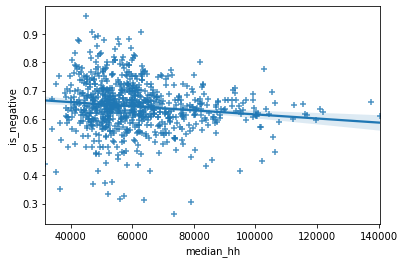

In [93]:
counties = raw.groupby(['fips']).agg({'is_negative':'mean', 'median_hh':'mean', 'unemp_rate':'mean', 'state_name':'max', 'count':'count'}).reset_index()

counties = counties[counties['count'] > 15]

sns.regplot(x='median_hh', y='is_negative', data=counties, marker='+')

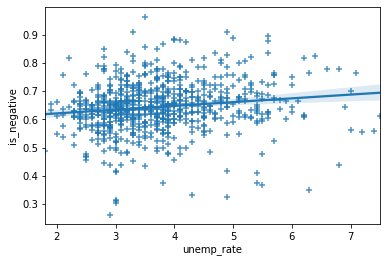

In [92]:
sns.regplot(x='unemp_rate', y='is_negative', data=counties, marker='+')